# Pipeline to compute UL metrics using Shimmer3 IMU sensors worn on both wrists and on the chest

This pipeline code was developed as part of a research project conducted over a period of 6 weeks at the FHT in Singapore. The goal of the project was to review and select which metrics are optimal to monitor upper limb (UL) use in daily life (DL) and to compute these metrics using Shimmer IMU sensors to validate the selection.

The research question addressed in this project was "Which metrics are the most representative of the upper limb use in daily life when using IMU sensors?" The dataset used for this project is a 24-hour recording of daily usage of the upper limb.

In [1]:
import pandas as pd
import csv
import numpy as np
from datetime import datetime
from matplotlib.colors import ListedColormap
from ahrs.filters import Mahony, Madgwick
from ahrs.common import orientation
import os
import pandas as pd
import csv
import numpy as np
from scipy import signal
from scipy.signal import butter, filtfilt
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from ahrs.filters import Madgwick
from mpl_toolkits.mplot3d import Axes3D
from scipy.signal import resample
import math
from scipy.signal import savgol_filter
from scipy.signal import freqz, butter, lfilter
from scipy import interpolate
from scipy.spatial.transform import Rotation
from scipy.stats import circmean
from scipy.interpolate import CubicSpline
from math import nan
from shimmer_data_extraction_functions import *
from shimmer_utilities_functions import *
from shimmer_metric_functions import *

C:\Users\Pierre-Louis\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Pierre-Louis\anaconda3\lib\site-packages\numpy\.libs\libopenblas.QVLO2T66WEPI7JZ63PS3HMOHFEY472BC.gfortran-win_amd64.dll
C:\Users\Pierre-Louis\anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
# Define folder containing the 3 datasets
folder = 'data'

# Define the input file paths
#LW: left wrist, RW: right wrist 
input_file_LW = os.path.join(os.getcwd(), folder, 'left.txt')
input_file_RW = os.path.join(os.getcwd(), folder, 'right.txt')
input_file_chest = os.path.join(os.getcwd(), folder, 'chest.txt')

In [3]:
# Define constants

RESAMPLING_FREQUENCY_LEUENBERGER = 50  # in Hz
RESAMPLING_FREQUENCY_LATERALITY = 1  # in Hz
ACTIVITY_THRESHOLD_LEUENBERGER = 0.05  # in g

In [4]:
#Define Timeline events 

SECONDS_PER_HOUR = 3600
SECONDS_PER_MINUTE = 60

# Start and end times in seconds since midnight
START_RECORDING = 0
SHOWER_EVENING_START = SECONDS_PER_HOUR * 10 + SECONDS_PER_MINUTE * 17
SHOWER_EVENING_END = SHOWER_EVENING_START + SECONDS_PER_MINUTE * 12
START_LYING = SECONDS_PER_HOUR * 11 + SECONDS_PER_MINUTE * 45
STOP_LYING = SECONDS_PER_HOUR * 14 + SECONDS_PER_HOUR * 8 + SECONDS_PER_MINUTE * 12
NAP_START = SECONDS_PER_HOUR * 6 + SECONDS_PER_MINUTE * 49
NAP_END = NAP_START + SECONDS_PER_MINUTE * 10
SHOWER_MORNING_START = SECONDS_PER_HOUR * 22 + SECONDS_PER_MINUTE * 13
SHOWER_MORNING_END = SHOWER_MORNING_START + SECONDS_PER_MINUTE * 15
END_RECORDING = START_RECORDING + SECONDS_PER_HOUR * 24 + SECONDS_PER_MINUTE * 28

# Create a list of tuples containing the start time and name of each event
EVENTS = [
    (START_RECORDING, 'Start Recording'),
    (NAP_START, 'Start Nap'),
    (NAP_END, 'End Nap'),
    (SHOWER_EVENING_START, 'Start Shower'),
    (SHOWER_EVENING_END, 'End Shower'),
    (START_LYING, 'Start Lying'),
    (STOP_LYING, 'Stop Lying'),
    (SHOWER_MORNING_START, 'Start Shower'),
    (SHOWER_MORNING_END, 'End Shower'),
    (END_RECORDING, 'End Recording')
]


In [5]:
#Extract raw data

data_RW = extract_from_raw_data(get_raw_data(input_file_RW))
data_LW = extract_from_raw_data(get_raw_data(input_file_LW))
data_chest = extract_from_raw_data(get_raw_data(input_file_chest))

Start data extraction
Start data extraction
Start data extraction


In [5]:
# # Load data from a saved numpy file
# data_RW = np.load('data_RW.npy', allow_pickle=True)
# data_LW = np.load('data_LW.npy', allow_pickle=True)
# data_chest = np.load('data_chest.npy', allow_pickle=True)

In [59]:
#Compute the sampling frequency

LW_frequency = get_sampling_frequency(get_timestamp(data_LW))
RW_frequency = get_sampling_frequency(get_timestamp(data_RW))
chest_frequency = get_sampling_frequency(get_timestamp(data_chest))
UL_frequency = np.mean([LW_frequency,RW_frequency])

In [7]:
#Synchronization step 

data_LW_selected, data_RW_selected, data_chest_selected = get_synch_data(data_LW, data_RW, data_chest)

Synchronization done


In [8]:
#Get recording time 

recording_time = get_recording_time(get_timestamp(data_LW_selected))

In [9]:
#Get quaternions

q_LW, q_RW, q_chest = get_quaternion(data_LW_selected),get_quaternion(data_RW_selected),get_quaternion(data_chest_selected)

In [10]:
#Get 9 DOF data

data_LW_9DOF,data_RW_9DOF, data_chest_9DOF = get_9_DOF(data_LW_selected),get_9_DOF(data_RW_selected),get_9_DOF(data_chest_selected)

In [11]:
#Get Euler angles

euler_angles_LW = get_euler_angles(data_LW_selected)
euler_angles_RW = get_euler_angles(data_RW_selected)

C:\Users\Pierre-Louis\Documents\SEC\SP\Shimmer3_IMU_Sample_Data\shimmer_data_extraction_functions.py:235: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.tight_layout()
C:\Users\Pierre-Louis\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


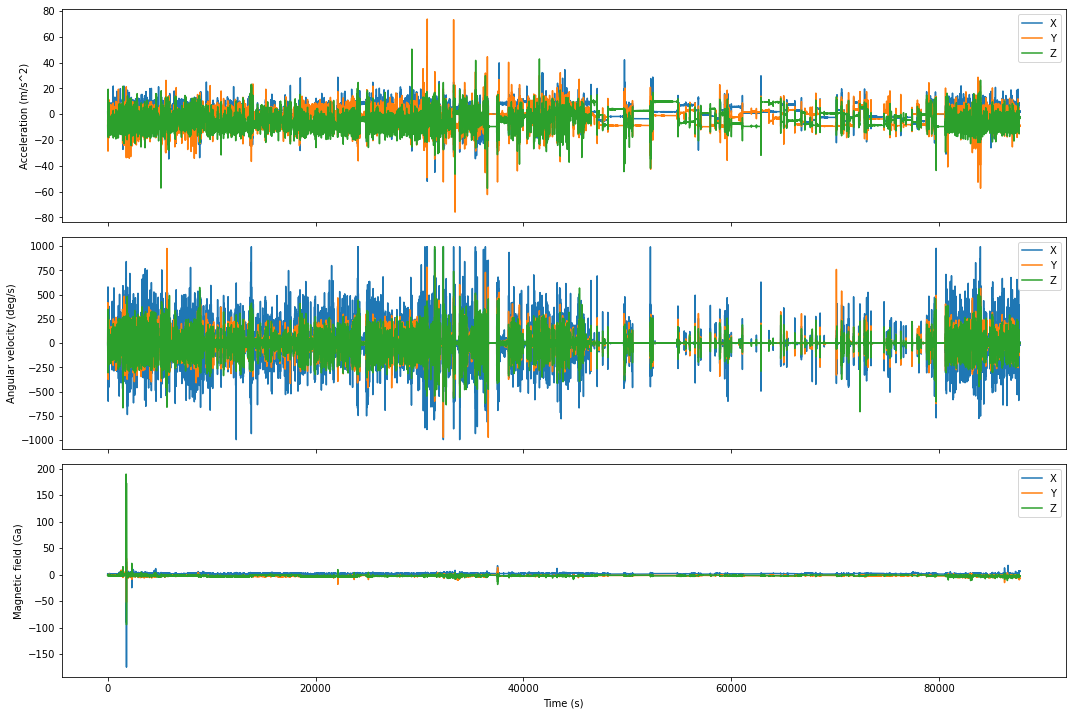

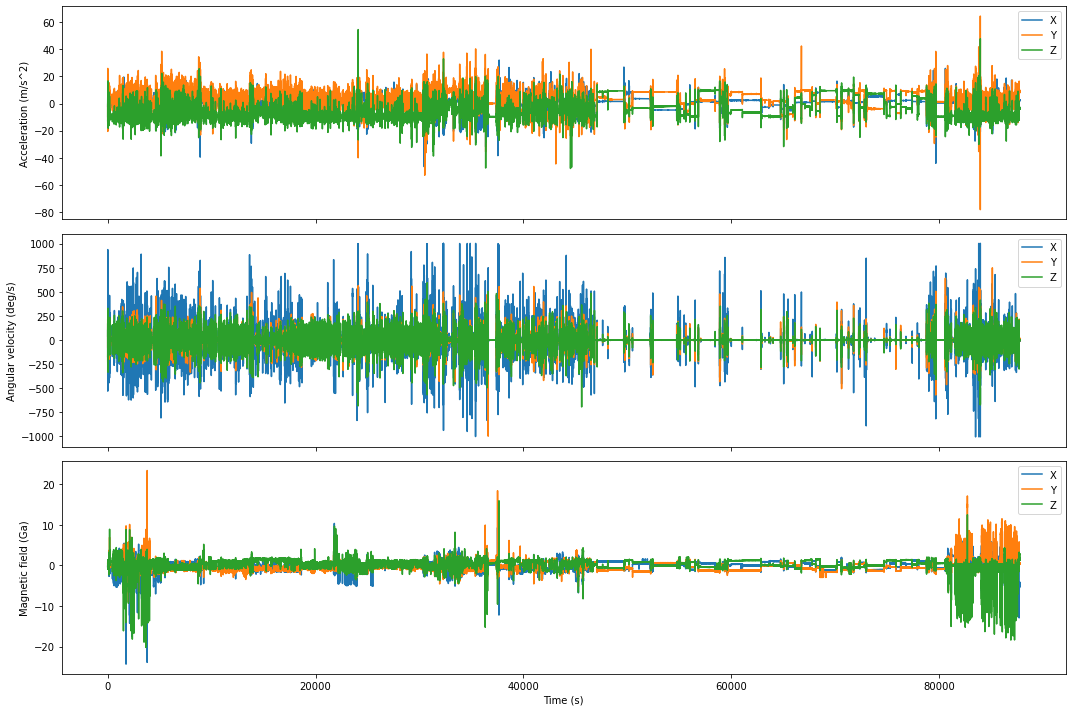

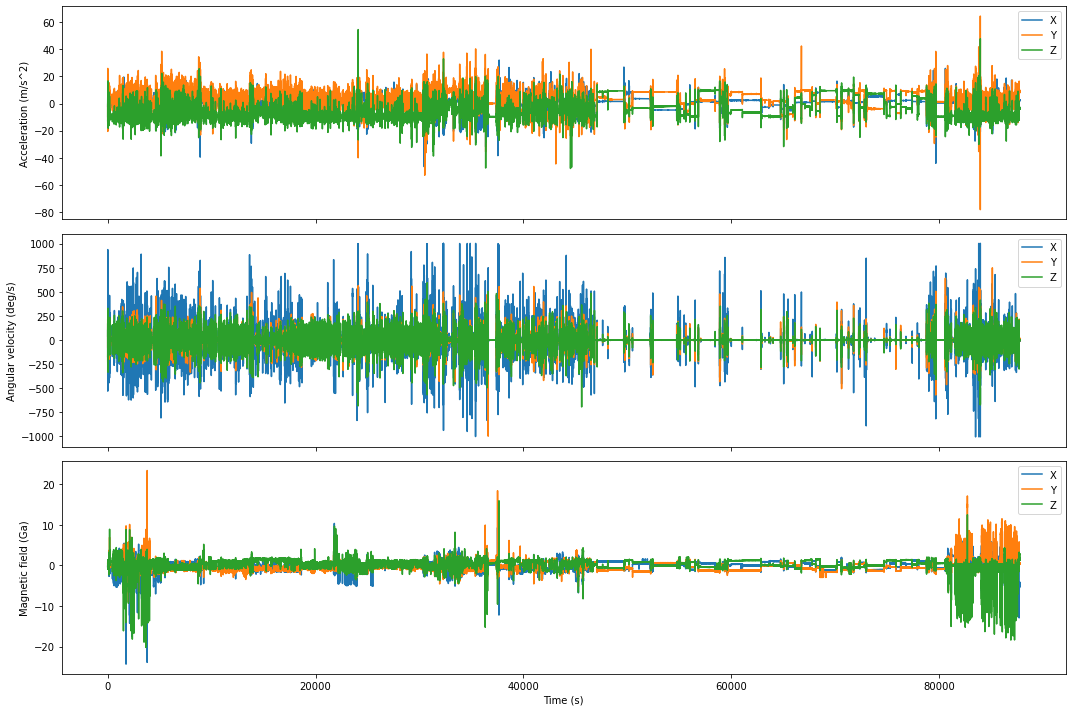

(None, None, None)

In [12]:
#Vizualisation of the raw data for the 3 sensors

plot_imu_data(data_LW_9DOF, LW_frequency),plot_imu_data(data_RW_9DOF, RW_frequency),plot_imu_data(data_chest_9DOF, chest_frequency)

In [13]:
#Preprocessing of the raw data using Leuenberger method

data_LW_filtered_leuenberger = preprocessing_leuenberger(data_LW_9DOF, UL_frequency,RESAMPLING_FREQUENCY_LEUENBERGER )
data_RW_filtered_leuenberger = preprocessing_leuenberger(data_RW_9DOF,UL_frequency,RESAMPLING_FREQUENCY_LEUENBERGER)
data_chest_filtered_leuenberger = preprocessing_leuenberger(data_chest_9DOF,chest_frequency,RESAMPLING_FREQUENCY_LEUENBERGER)

C:\Users\Pierre-Louis\Documents\SEC\SP\Shimmer3_IMU_Sample_Data\shimmer_data_extraction_functions.py:235: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.tight_layout()


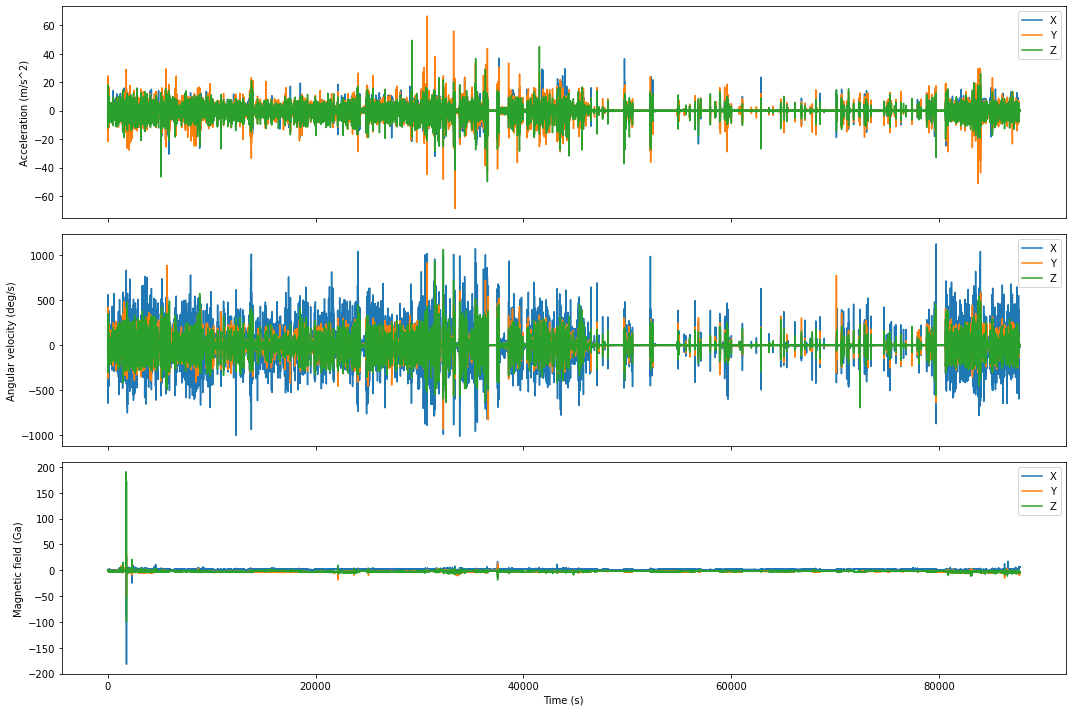

In [15]:
#Vizualisation of the filtered data for the 3 sensors

plot_imu_data(data_LW_filtered_leuenberger, RESAMPLING_FREQUENCY_LEUENBERGER)

In [16]:
#Get acceleration magnitudes 

accel_leuenberger_LW = get_accel_mag(data_LW_filtered_leuenberger[:,0:3],ACTIVITY_THRESHOLD_LEUENBERGER)
accel_leuenberger_RW = get_accel_mag(data_RW_filtered_leuenberger[:,0:3],ACTIVITY_THRESHOLD_LEUENBERGER)

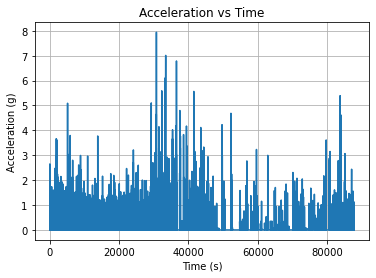

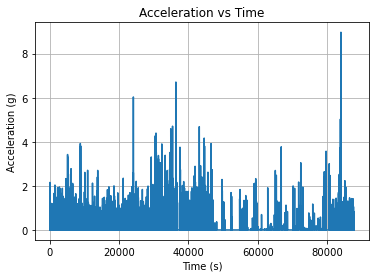

{'mean': 0.04965595485807165, 'median': 0.0, 'iqr': 0.0, 'range': 7.940808415506442, 'std': 0.13882931309294785, 'max': 7.940808415506442, 'min': 0.0, 'num_elements': 4389124}
{'mean': 0.048613650336829135, 'median': 0.0, 'iqr': 0.0, 'range': 8.971817082905805, 'std': 0.13628984210731965, 'max': 8.971817082905805, 'min': 0.0, 'num_elements': 4389124}


In [18]:
#Vizualisation and statistics of the filtered data for the 2 wrist sensors

plot_acceleration_over_time(convert_ms2_to_g(accel_leuenberger_LW),recording_time),plot_acceleration_over_time(convert_ms2_to_g(accel_leuenberger_RW),recording_time)
print(get_statistics(convert_ms2_to_g(accel_leuenberger_LW)))
print(get_statistics(convert_ms2_to_g(accel_leuenberger_RW)))

In [19]:
#Active percentage of acceleration data for both wrists

print(get_active_percentage(accel_leuenberger_LW))
print(get_active_percentage(accel_leuenberger_RW))

20.73819286035209
19.80875910546159


In [98]:
#AC computation using Leuenberger method

#Choose the epoch size in seconds size for the computation of AC per epoch
epoch_AC = SECONDS_PER_MINUTE*10

AC_per_epoch_LW = calculate_activity_counts(accel_leuenberger_LW, epoch_AC, RESAMPLING_FREQUENCY_LEUENBERGER, ACTIVITY_THRESHOLD_LEUENBERGER)
AC_per_epoch_RW = calculate_activity_counts(accel_leuenberger_RW, epoch_AC, RESAMPLING_FREQUENCY_LEUENBERGER, ACTIVITY_THRESHOLD_LEUENBERGER)

In [99]:
#Get the active percentage of AC epochs through the recording

print(get_active_percentage(AC_per_epoch_LW))
print(get_active_percentage(AC_per_epoch_RW))

91.0958904109589
86.98630136986301


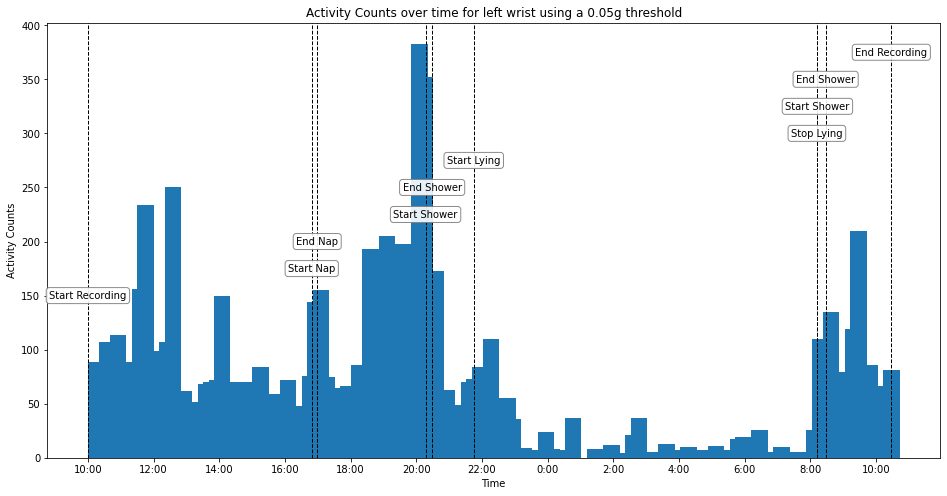

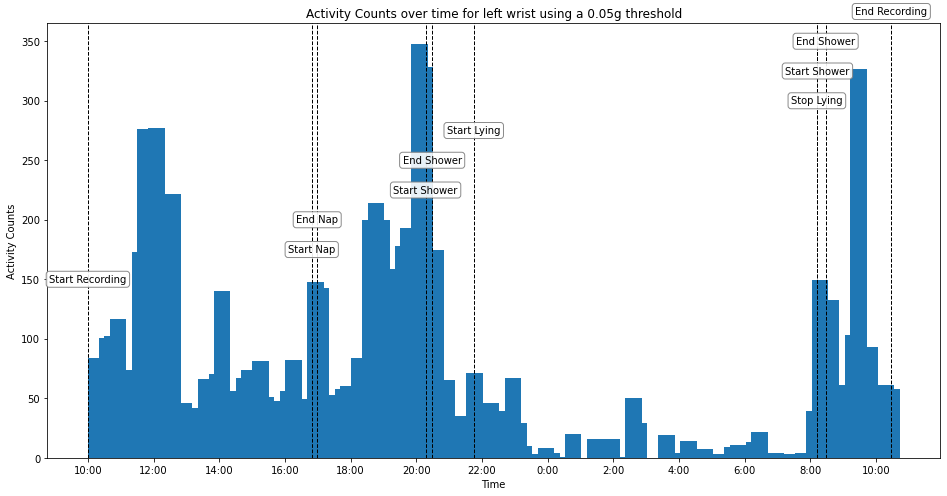

In [100]:
#Vizualisation of the AC per epochs for each wrists with events

plot_activity_counts_with_events(AC_per_epoch_LW, recording_time, EVENTS)
plot_activity_counts_with_events(AC_per_epoch_RW, recording_time, EVENTS)

C:\Users\Pierre-Louis\Documents\SEC\SP\Shimmer3_IMU_Sample_Data\shimmer_metric_functions.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f'{tick_label}' for tick_label in ax.get_yticks()], fontsize=font_size)


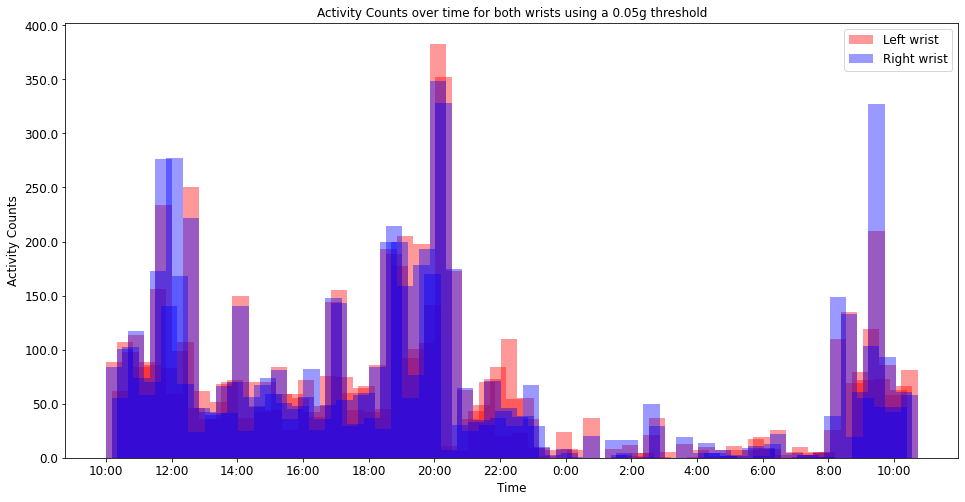

In [101]:
#Vizualisation of the AC per epochs for both wrists 

plot_activity_counts_superposition(AC_per_epoch_LW, AC_per_epoch_RW, recording_time)

In [24]:
#Get some statistics about the AC per wrist
print(get_statistics(AC_per_epoch_RW))
print(get_statistics(AC_per_epoch_LW))

{'mean': 58.17084368093687, 'median': 0.0, 'iqr': 13.0, 'range': 1720.0, 'std': 141.27314069168503, 'max': 1720.0, 'min': 0.0, 'num_elements': 87782}
{'mean': 59.4245631222802, 'median': 0.0, 'iqr': 19.0, 'range': 2133.0, 'std': 144.2267283132022, 'max': 2133.0, 'min': 0.0, 'num_elements': 87782}


In [25]:
# #Using MARG Madgwick algorithm (very long computation)

# q_LW_mad = compute_quaternions_madgwick(data_LW_9DOF)
# q_RW_mad = compute_quaternions_madgwick(data_RW_9DOF)
# #Compute DCMS from the Madgwick quaternions
# R_LW_mad = compute_dcms(q_LW_mad)
# R_RW_mad = compute_dcms(q_RW_mad)
# #Compute the angles 
# thetas_from_dcm_mad_LW = compute_pitch_from_dcm(R_LW_mad)
# thetas_from_dcm_mad_RW = compute_pitch_from_dcm(R_RW_mad)
# yaw_from_dcm_mad_LW = calculate_yaw_from_dcms(R_LW_mad)
# yaw_from_dcm_mad_RW = calculate_yaw_from_dcms(R_RW_mad)

# print(get_statistics(thetas_from_dcm_mad_LW))
# print(get_statistics(yaw_from_dcm_mad_LW))

In [26]:
# #Using the quaternions extracted from the sensor (long computation)

# #Compute DCMS from the sensor quaternions
# R_LW_sens = compute_dcms(q_LW)
# R_RW_sens = compute_dcms(q_RW)
# #Compute the angles 
# thetas_from_dcm_sens_LW = compute_pitch_from_dcm(R_LW_sens)
# thetas_from_dcm_sens_RW = compute_pitch_from_dcm(R_RW_sens)
# yaw_from_dcm_sens_LW = calculate_yaw_from_dcms(R_LW_sens)
# yaw_from_dcm_sens_RW = calculate_yaw_from_dcms(R_RW_sens)
# print(get_statistics(thetas_from_dcm_sens_LW))
# print(get_statistics(yaw_from_dcm_sens_LW))

In [27]:
#Using the Euler angles extracted from the sensor

theta_euler_LW = euler_angles_LW[:,0]
roll_euler_LW = euler_angles_LW[:,1]
yaw_euler_LW = euler_angles_LW[:,2]

theta_euler_RW = euler_angles_RW[:,0]
roll_euler_RW = euler_angles_RW[:,1]
yaw_euler_RW = euler_angles_RW[:,2]
print(get_statistics(theta_euler_LW))
#Vizualisation of the AC per epochs for both wrists print(get_statistics(yaw_euler_LW))

{'mean': -6.700409452218776, 'median': -1.459922133689578, 'iqr': 35.5393203564238, 'range': 179.88628423322254, 'std': 31.01172361519127, 'max': 89.95260274998624, 'min': -89.9336814832363, 'num_elements': 4417608}


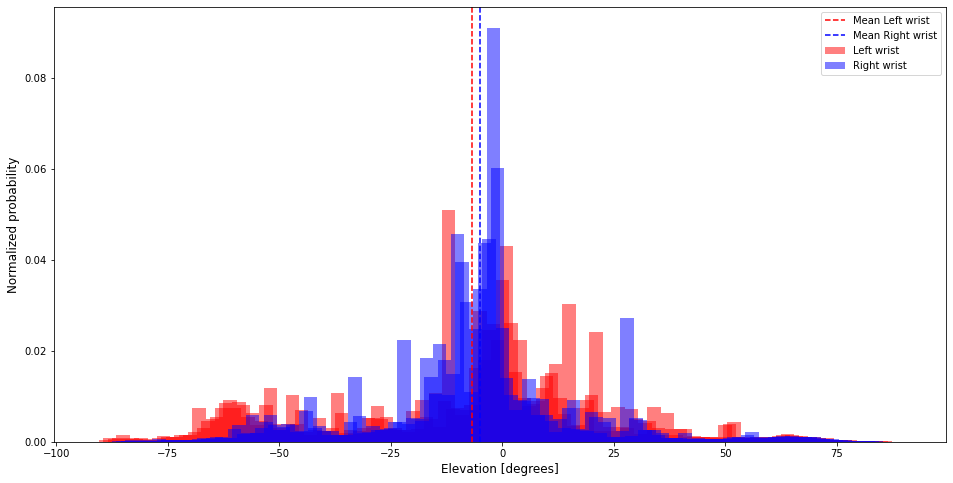

In [28]:
#Vizualisation of the forearm elevation for both wrists using the Euler angles from the sensor
get_normalized_histogram_superpose_elevation(theta_euler_LW, theta_euler_RW)

In [29]:
#Get the percentage of angles inside the 'functionnal space'
print(get_ratio_active_zone(theta_euler_LW))
print(get_ratio_active_zone(theta_euler_RW))

69.19022692823809
81.41876780375263


In [30]:
#Compute GM scores using Leuenberger method
gm_LW=compute_GM(theta_euler_LW,yaw_euler_LW)
gm_RW=compute_GM(theta_euler_RW,yaw_euler_RW)

In [31]:
#Get percentage of active GM scores 
print(get_active_percentage(gm_LW))
print(get_active_percentage(gm_RW))

7.643813134885827
11.394697376984238


In [32]:
#Get GM scores per epoch 
epoch_GM = SECONDS_PER_MINUTE*10

gm_per_epoch_LW = get_gm_per_epoch(gm_LW, epoch_GM)
gm_per_epoch_RW = get_gm_per_epoch(gm_RW, epoch_GM)

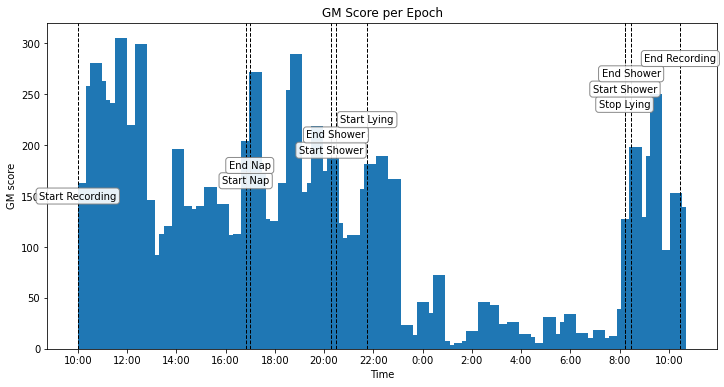

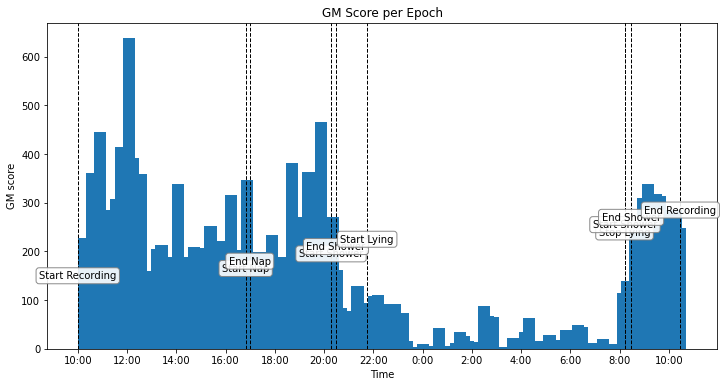

In [33]:
#Vizualisation of GM scores for each wrist with timeline events
plot_gm_epoch(gm_per_epoch_LW,recording_time, EVENTS)
plot_gm_epoch(gm_per_epoch_RW,recording_time, EVENTS)

C:\Users\Pierre-Louis\Documents\SEC\SP\Shimmer3_IMU_Sample_Data\shimmer_metric_functions.py:474: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f'{tick_label}' for tick_label in ax.get_yticks()], fontsize=font_size)


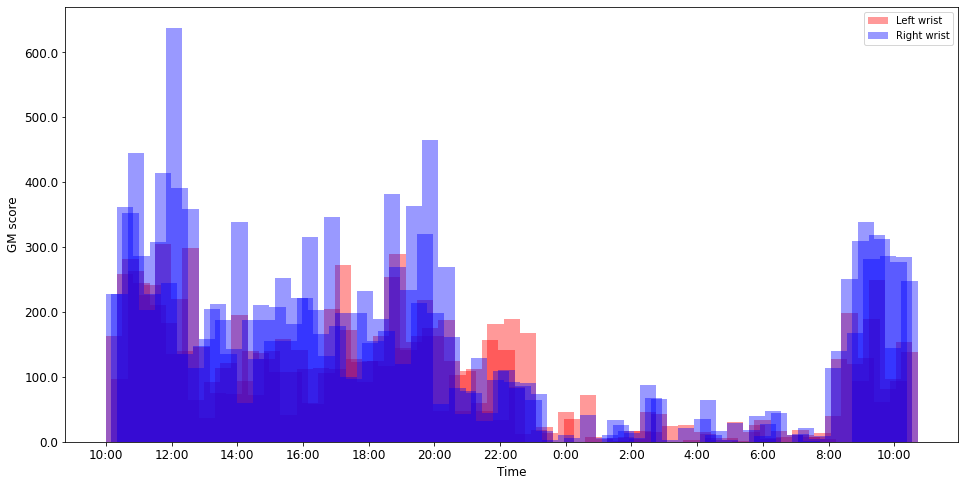

In [34]:
#Vizualisation of GM scores for both wrists superposed 
plot_gm_superposed(gm_per_epoch_LW, gm_per_epoch_RW, recording_time)

In [35]:
#Compute GMAC scores
GMAC_LW =compute_GMAC(theta_euler_LW,accel_leuenberger_LW,recording_time, UL_frequency, RESAMPLING_FREQUENCY_LEUENBERGER, ACTIVITY_THRESHOLD_LEUENBERGER)
GMAC_RW =compute_GMAC(theta_euler_RW,accel_leuenberger_RW,recording_time, UL_frequency, RESAMPLING_FREQUENCY_LEUENBERGER, ACTIVITY_THRESHOLD_LEUENBERGER)

In [36]:
#Compute active GMAC scores
print(get_active_percentage(GMAC_LW))
print(get_active_percentage(GMAC_RW))

19.70107766968171
24.47198742338976


In [37]:
#Get active percentage for each wrists 
#Note: Need the AC scores to be computed for 1s epoch 
left_wrist_scores = [get_active_percentage(AC_per_epoch_LW),get_active_percentage(GMAC_LW),get_active_percentage(gm_LW)]
right_wrist_scores = [get_active_percentage(AC_per_epoch_RW),get_active_percentage(GMAC_RW),get_active_percentage(gm_RW)]

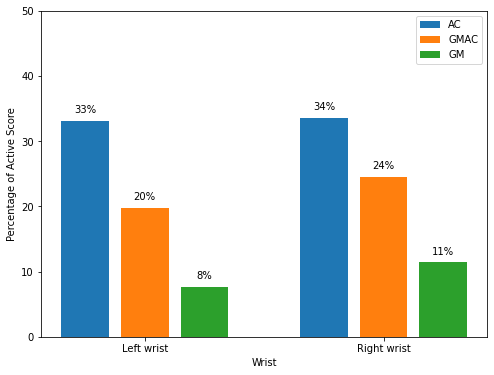

In [38]:
#Vizualisation of active score for AC, GM, GMAC over 1s epochs
plot_active_scores_comparison(left_wrist_scores,right_wrist_scores)

In [39]:
#Compute GMAC scores per epoch 
epoch_GMAC = SECONDS_PER_MINUTE * 10
GMAC_per_epoch_LW = compute_gmac_per_epoch(GMAC_LW, epoch_GMAC)
GMAC_per_epoch_RW = compute_gmac_per_epoch(GMAC_RW, epoch_GMAC)

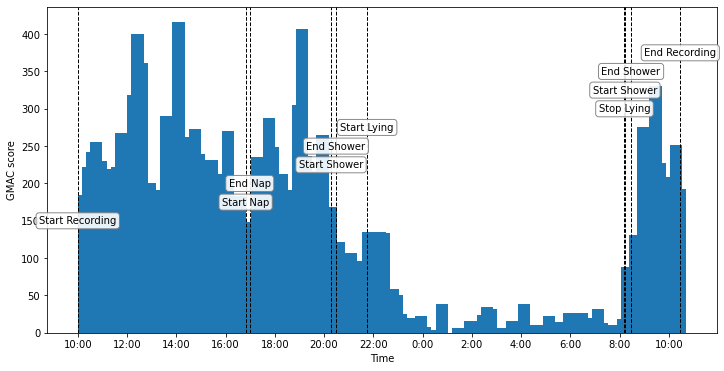

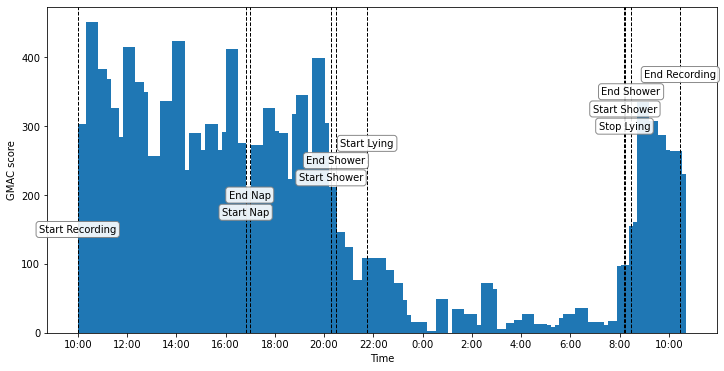

In [40]:
#Vizualisation of GMAC scores for each wrist with timeline events
plot_gmac_epoch(GMAC_per_epoch_LW,recording_time, EVENTS)
plot_gmac_epoch(GMAC_per_epoch_RW,recording_time, EVENTS)

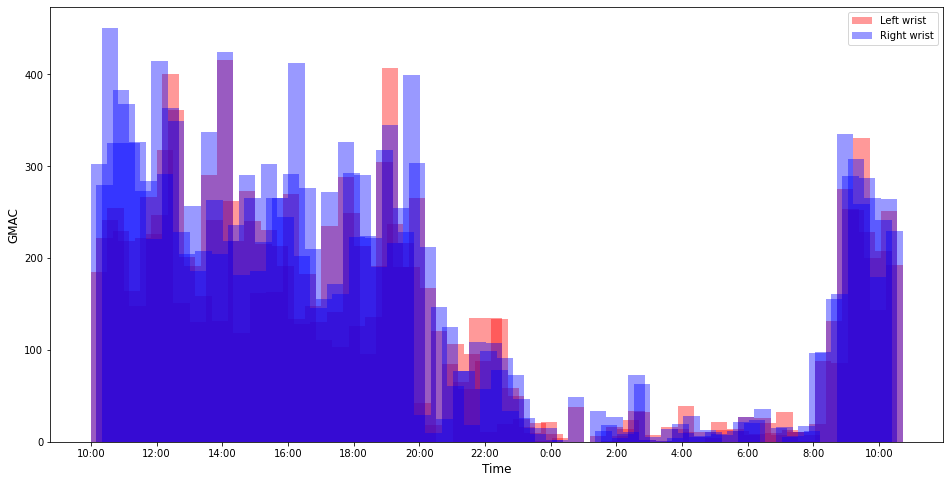

In [41]:
#Vizualisation of superposed GMAC scores for both wrists 
plot_gmac_superposed(GMAC_per_epoch_LW, GMAC_per_epoch_RW, recording_time)

In [42]:
#Compute Bilateral Magnitude 
bm = get_bilateral_magnitude(accel_leuenberger_LW, accel_leuenberger_RW, ACTIVITY_THRESHOLD_LEUENBERGER,RESAMPLING_FREQUENCY_LEUENBERGER, RESAMPLING_FREQUENCY_LATERALITY)
print(get_statistics(bm))

{'mean': 1.7672897941514871, 'median': 0.0, 'iqr': 1.0, 'range': 81.0, 'std': 4.3074597811584825, 'max': 81.0, 'min': 0.0, 'num_elements': 87783}


In [43]:
#Compute Magnitude Ratio 
ratio = get_magnitude_ratio(accel_leuenberger_LW,accel_leuenberger_RW, bm, ACTIVITY_THRESHOLD_LEUENBERGER,RESAMPLING_FREQUENCY_LEUENBERGER, RESAMPLING_FREQUENCY_LATERALITY)
print(get_statistics(ratio))

{'mean': 0.22052587115466182, 'median': 0.0, 'iqr': 14.0, 'range': 14.0, 'std': 5.442511057814299, 'max': 7.0, 'min': -7.0, 'num_elements': 87783}


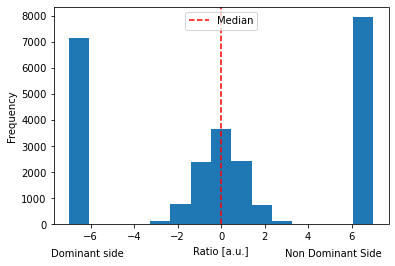

In [44]:
#Vizualisation of the Magnitude Ratios distribution over the recording
plot_distribution_ratio(ratio)

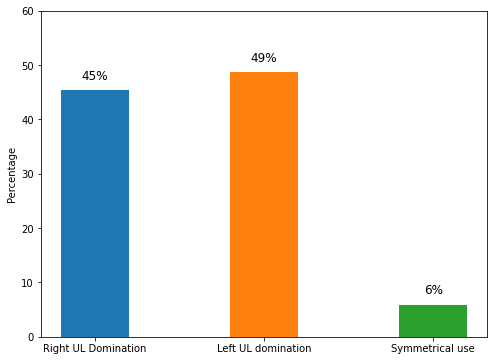

In [45]:
#Vizualisation of the Magnitude Ratios tendency 
plot_ratio_tendency(ratio)

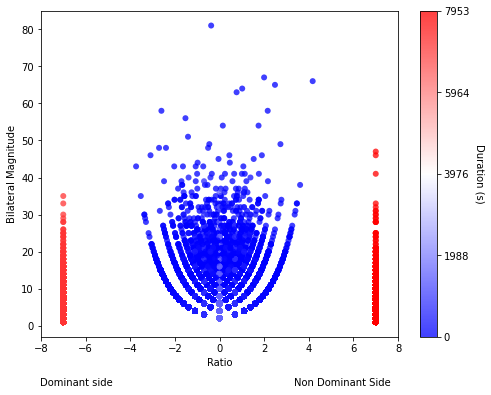

In [47]:
#Vizualisation using a density plot for the MR and the BM combined
plot_density(bm, ratio)